### evaluate a model by draw prediction visually for a lond horizon

base: 11./evaluate_model_visualdraw

+ visualization of pitagemodel



In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import indycar.model.evaluate_fulltest_fastrun_paper as ev

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Load Data

In [2]:
import os
os.getcwd()

'/scratch/hpda/indycar/notebook/21.PaperReady'

#### evaluate

In [3]:
def plot_prob_forecasts(ts_entry, forecast_entry, outputfile):

    plot_length = context_length 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)

    #fig, axs = plt.subplots(figcnt, 1, figsize=(10, 7))

    #for idx in range(figcnt):

    #    ts_entry[idx][-plot_length:].plot(ax=axs[idx])  # plot the time series
    #    forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
    #    axs[idx].grid(which="both")
    #    axs[idx].legend(legend, loc="upper left")
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(10, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()

def evaluate_model(predictor, evaluator, test_ds, outputfile):
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    
    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    #convert to univariate format
    # tss: <ts_len, #feature>
    # forecasts.sample: < 100, prediction_length, #feature>
   
    #tss_n = []
    #for ts in tss:
    #    tse = ts.to_numpy()
    #    tss_n.append(tse[:,0].reshape((tse.shape[0])))
    #cast_n = []
    #for fc in forecasts:
    #    nfc = fc
    #    fcs = fc.samples.shape
    #    nsamples = fc.samples[:,:,0].reshape((fcs[0], fcs[1]))
    #    nfc.samples = nsamples
    #    cast_n.append(nfc)
    #tss = tss_n
    #forecasts = cast_n


    # car12@rank1, car1@rank16, car7@rank33, the index is 7,0,4 accordingly
    # Indy500 Car 12 WillPower
    #offset = 52-7
    offset = 0
    ts_entry = [tss[7+offset],tss[0+offset],tss[4+offset]]
    forecast_entry = [forecasts[7+offset],forecasts[0+offset],forecasts[4+offset]]

    #debug
    #print(f'ts_entry shape:{ts_entry[0].shape}, forecast:{forecast_entry[0].samples.shape}')

    plot_prob_forecasts(ts_entry, forecast_entry, outputfile)
    
    #evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    
    
    print(json.dumps(agg_metrics, indent=4))
        

In [149]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        
        
        
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        

        #axs.set_xlim((80,110))
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        
        # set the x ticks
        #xtickslocs = plt.gca().get_xticks()
        #print(xtickslocs)
        #ticks = [tick for tick in plt.gca().get_xticklabels()]
        #print(ticks)        
        
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 10)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)
        
        
        
        
        plt.show()
        


In [151]:
def long_predict(output):
    """
    use the farest samples only
    
    input:
        test_ds
        predictor
    
    """
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))

    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        

    target.samples = newsamples

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target, tss[0]

### evaluate

In [6]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}


In [7]:
prediction_length = 2
freq = '1min'

In [8]:
ev._dataset_id = 'indy2013-2018-nocarid'
ev._dataset_id = 'indy2013-2018'
#_test_event = 'Indy500-2019'
ev._test_event = 'Indy500-2018'

ev._task_id = 'rank'  # rank,laptime, the trained model's task
ev._run_ts = ev.COL_RANK   #COL_LAPTIME,COL_RANK
ev._exp_id='rank'  #rank, laptime, laptim2rank, timediff2rank... 

ev._feature_mode = ev.FEATURE_STATUS
ev._context_ratio = 0.

ev.init()

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


In [9]:
#ev._dataset_id = 'indy2013-2018-pitagemodel'
#ev._test_event = 'Indy500-2018'
##_test_event = 'Indy500-2019'

#ev._feature_mode = ev.FEATURE_TRACKONLY
#ev._context_ratio = 0.

##rootdir = f'../models/remote/{_dataset_id}/{_task_id}-{trainid}/'
#ev._task_id = 'pitage'  # rank,laptime, the trained model's task
#ev._run_ts = ev.COL_LAPS_INSTINT   #COL_LAPTIME,COL_RANK
#ev._exp_id='pitage'  #rank, laptime, laptim2rank, timediff2rank... 

#ev.init()



In [10]:
test_cars = [12]
save_prefix = 'test-' + ev._test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

In [13]:
train_ds, test_ds,_,_ = ev.make_dataset_byevent(events_id[ev._test_event], prediction_length,freq, 
                                     oracle_mode=ev.MODE_ORACLE,
                                     run_ts = ev._run_ts,
                                     test_event = ev._test_event,
                                     test_cars=test_cars,
                                     half_moving_win = 0,
                                     train_ratio = 0.4)


train len:0, test len:188, mae_track:0.0,mae_lap:0.0,


INFO:root:Using GPU


predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
[25771680 25771740 25771800 25771860 25771879]
[Text(25771680, 0, '00:00\n01-Jan\n2019'), Text(25771740, 0, '01:00'), Text(25771800, 0, '02:00'), Text(25771860, 0, '03:00'), Text(25771879, 0, '')]


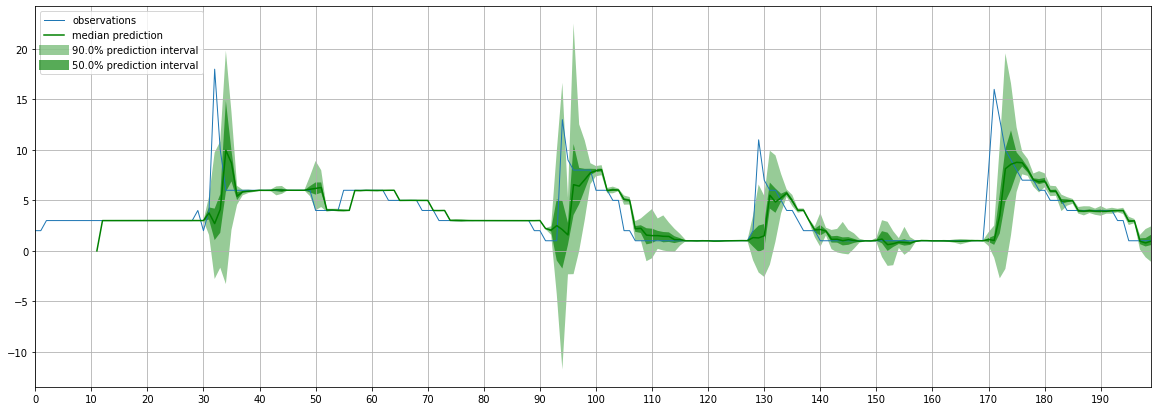

In [88]:
#ev._dataset_id = 'indy2013-2018-pitagemodel-context40'
predictor = ev.load_model('oracle', '2018',prediction_length)
target_ranknet = long_predict('deepAR-Oracle-context40-nextpit')

INFO:root:Using GPU


predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2


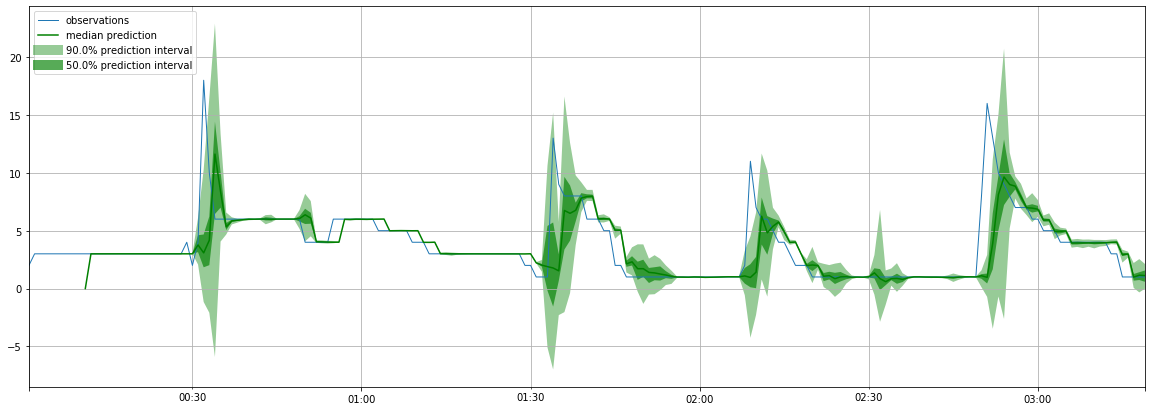

In [63]:
#ev._dataset_id = 'indy2013-2018-pitagemodel-context40'
predictor = ev.load_model('oracle', '2018',prediction_length)
target_ranknet = long_predict('deepAR-Oracle-context40-nextpit')

In [50]:
target_ranknet.samples

array([[ 0.        ,  2.99402332,  3.00713491, ...,  0.8090542 ,
         8.11760616,  2.63059235],
       [ 0.        ,  2.99927926,  2.99093223, ...,  0.48560414,
         1.50073063, 11.14237976],
       [ 0.        ,  2.9957304 ,  3.00364137, ...,  0.92656797,
         0.54669487, -0.24416448],
       ...,
       [ 0.        ,  2.99500942,  2.99823856, ...,  0.76076561,
         3.85762787,  0.94878322],
       [ 0.        ,  2.98849273,  3.00522089, ...,  1.01378274,
         0.62665057,  0.62071007],
       [ 0.        ,  2.98107529,  2.99934101, ...,  0.67046875,
         1.5137167 ,  1.60966754]])

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
[25771680 25771740 25771800 25771860 25771879]
[Text(25771680, 0, '00:00\n01-Jan\n2019'), Text(25771740, 0, '01:00'), Text(25771800, 0, '02:00'), Text(25771860, 0, '03:00'), Text(25771879, 0, '')]


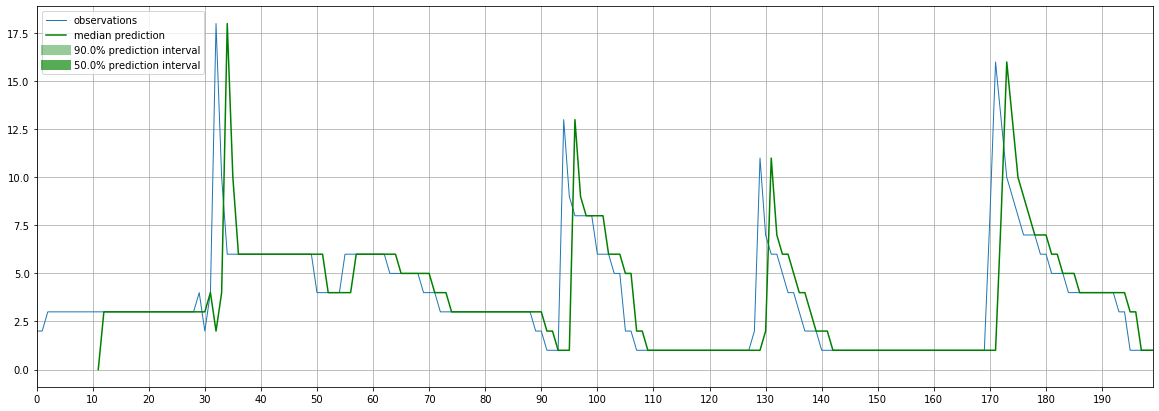

In [87]:
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
target_navie = long_predict('naive-vspeed')

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2


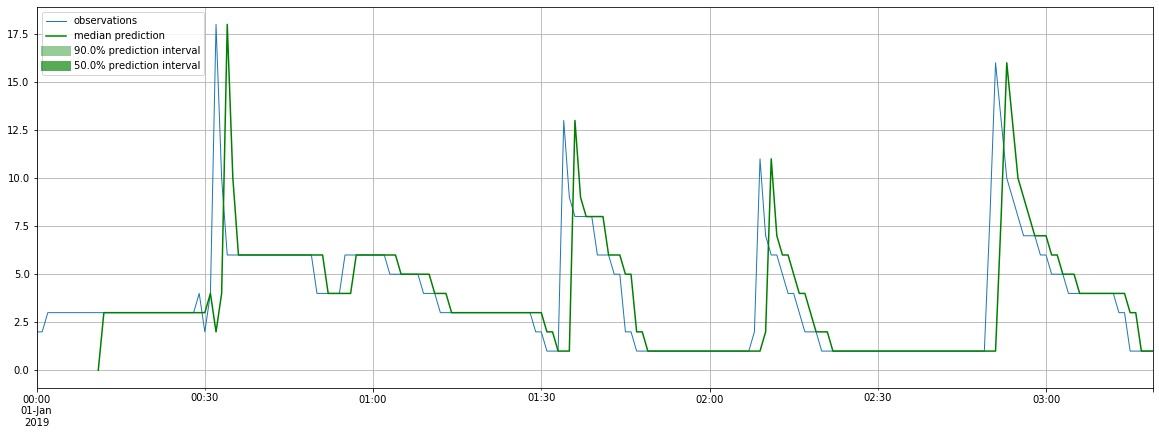

In [51]:
#load predictor
#model='naive-vspeed-nolap-indy-f1min-t10-e1000-r1'
#modeldir = '../models/' + model
#predictor =  Predictor.deserialize(Path(modeldir))
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
target_navie = long_predict('naive-vspeed')

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]


tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2


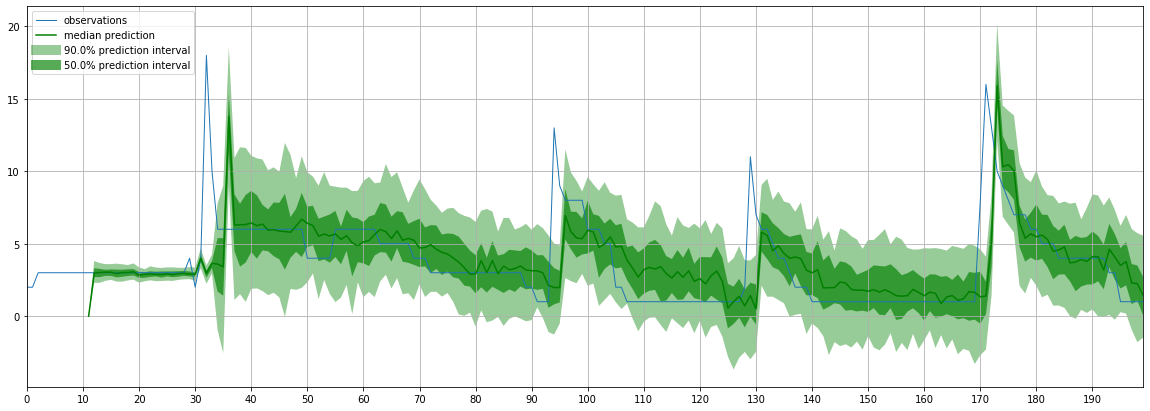

In [90]:
predictor =  RForecastPredictor(method_name='arima',freq= freq, 
                                            prediction_length = prediction_length,trunc_length=40)
target_arima, tss_arima = long_predict('arima-rank')

### test

In [20]:
prediction_length = 10
context_length = 20
model='deepAR-Oracle-vspeed-nolap-indy-f1min-t10-e1000-r1'
freq = "1min"

cardinality = [len(global_carids)]
interpolate = False
ipstr = '' if interpolate else '-noip'
test_cars = [12]
test_event = 'Indy500'
save_prefix = 'test-' + test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'
#make_gluontsdb(events_id[test_event])

train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         interpolate=interpolate,test_cars=test_cars)

#get target dim
entry = next(iter(train_ds))
target_dim = entry['target'].shape
target_dim = target_dim[0] if len(target_dim) > 1 else 1
print('target_dim:%s', target_dim)

NameError: name 'global_carids' is not defined

In [ ]:
#if target_dim > 1:
#    evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
#else:
#    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

evaluate_model(predictor, evaluator, test_ds, outputfile)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

forecasts = list(forecast_it)
tss = list(ts_it)
print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')

In [ ]:
tsslen = [len(tss[x]) for x in range(len(tss))]
print(tsslen[-1])
np.mean(tsslen)

In [ ]:
start_time, row = next(tss[0].iterrows())
start_time

In [ ]:
fstart = [forecasts[x].start_date for x in range(len(forecasts))]

In [ ]:
fstart

In [ ]:
td = forecasts[-1].start_date - start_time

In [ ]:
td.days*24*60 + td.seconds//60

In [ ]:
len(tss[-1])

In [ ]:
forecasts[0]

In [ ]:
forecasts[0].samples.shape

In [ ]:
def get_start(idx):
    td = forecasts[idx].start_date - start_time
    return td.days*24*60 + td.seconds//60
    

first_start = get_start(-1)
last_start = get_start(0)
print(first_start, last_start)

In [ ]:
import copy
target = copy.deepcopy(forecasts[-1])

In [ ]:
target

In [ ]:
#100, 10
nsample, npredict = target.samples.shape
print('sampel# x predictlen: ', nsample, npredict)
newsamples = np.zeros((2*nsample, last_start - first_start + npredict))

blockid = 0
for idx in range(len(forecasts)):
    #copy samples
    start_pos = get_start(idx)
    
    pos = start_pos - first_start
    #copy sample to block
    newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples
    
    blockid = (blockid + 1) % 2
    
#first block
newsamples[nsample*blockid: nsample*blockid + nsample, 0:0 + npredict] = forecasts[-1].samples

#last block
blockid = 1
newsamples[nsample*blockid: nsample*blockid + nsample, last_start- first_start:last_start- first_start + npredict] = forecasts[0].samples


    

In [ ]:
newsamples.shape

In [ ]:
target.samples = newsamples
target

In [ ]:
target.samples.shape

In [ ]:
context_length = 0
plot_prob_forecasts_ex([tss[0]],[target],'output')

In [ ]:
a=np.array([2,3,4,5,0,2,0])
(a>0)*0.1 + (a==0)* 1


### load model from dfout

In [24]:
def load_dfout(datafile):
    #with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        
        return dfout[0]

In [144]:
### load ml models
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''
outfile=f'shortterm-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-rerank-t{_trim}.pickle'
preddf = load_dfout(outfile)

outfile=f'shortterm-dfout-ranknet-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}.pickle'
ranknet_df = load_dfout(outfile)

In [145]:
ranknet_df['2018'].keys()

dict_keys(['oracle-TIMEDIFF-2018-inlap-nopitage'])

In [38]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]

In [40]:
dfin.head(2)

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
7,12.0,9.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0
40,12.0,10.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0


In [183]:
def long_predict_bymloutput(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

In [112]:
len(dfin)

188

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


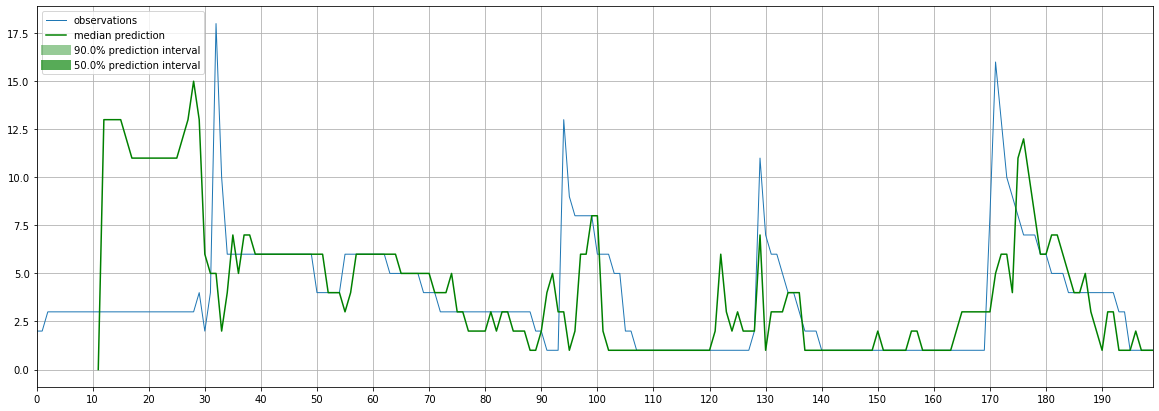

In [130]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
target_rf = long_predict_bymloutput('rf-rank', dfin)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


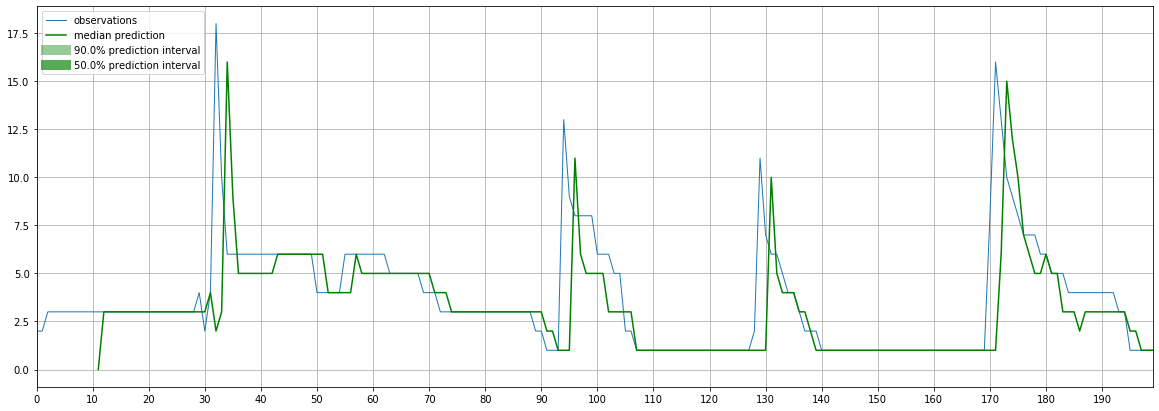

In [131]:
df = preddf['2018']['lasso']
dfin = df[df['carno']==test_cars[0]]
target_lasso = long_predict_bymloutput('lasso-rank', dfin)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


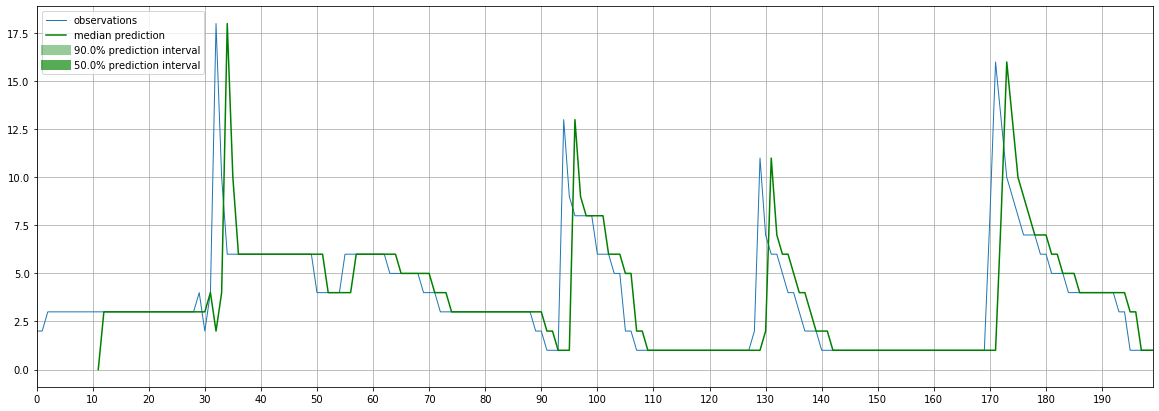

In [132]:
df = preddf['2018']['currank']
dfin = df[df['carno']==test_cars[0]]
target_lasso = long_predict_bymloutput('currank-rank', dfin)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


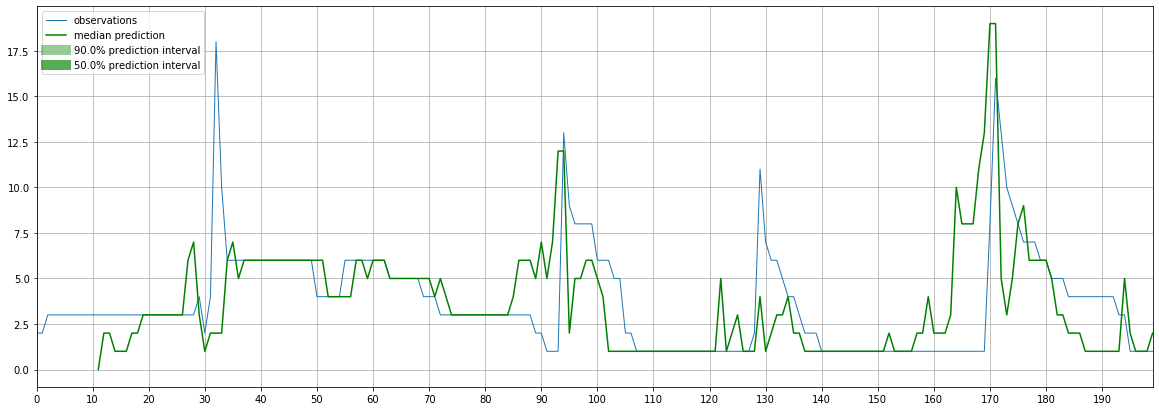

In [133]:
df = preddf['2018']['xgb']
dfin = df[df['carno']==test_cars[0]]
target_lasso = long_predict_bymloutput('xgb-rank', dfin)

tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


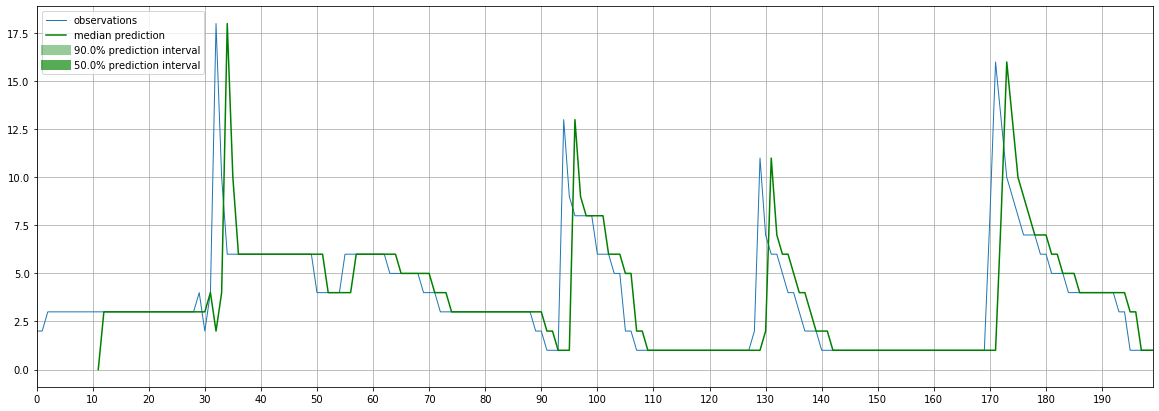

In [178]:
df = preddf['2018']['svr']
dfin = df[df['carno']==test_cars[0]]
target_lasso = long_predict_bymloutput('currank-rank', dfin)

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


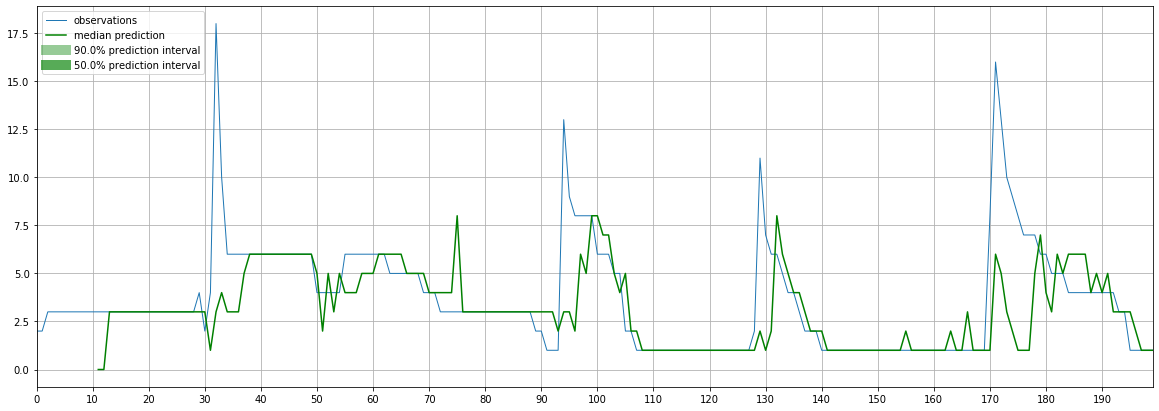

In [179]:
df = ranknet_df['2018']['oracle-TIMEDIFF-2018-inlap-nopitage']
dfin_ranknet = df[df['carno']==test_cars[0]]
target_ranknet, tss_ranknet = long_predict_bymloutput('ranknet-rank', dfin_ranknet)

In [128]:
dfin[(dfin['startlap']>=27) &(dfin['startlap']<35)]

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
601,12,27,2,1,2,-1,-1,0,0
634,12,28,3,3,3,0,0,0,0
667,12,29,1,17,1,16,1,0,0
700,12,30,3,9,3,6,1,0,0
733,12,31,17,5,17,-12,-1,0,0
766,12,32,9,5,9,-4,-1,0,0
799,12,33,5,5,5,0,0,0,0
832,12,34,5,5,5,0,0,0,0


In [92]:
dfin[dfin['startlap']==120]

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
3380,12.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
target_navie.samples

array([[0., 3., 3., ..., 1., 1., 1.],
       [0., 3., 3., ..., 1., 1., 1.],
       [0., 3., 3., ..., 1., 1., 1.],
       ...,
       [0., 3., 3., ..., 1., 1., 1.],
       [0., 3., 3., ..., 1., 1., 1.],
       [0., 3., 3., ..., 1., 1., 1.]])

In [55]:
sorted(set(dfin.startrank.values))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 17.0]

In [56]:
sorted(set(dfin.pred_endrank.values))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0, 12.0, 14.0]

### multi draw

In [229]:
#arima
predictor =  RForecastPredictor(method_name='arima',freq= freq, 
                                            prediction_length = prediction_length,trunc_length=40)
target_arima, tss_arima = long_predict('arima-rank')

#ranknet
df = ranknet_df['2018']['oracle-TIMEDIFF-2018-inlap-nopitage']
dfin_ranknet = df[df['carno']==test_cars[0]]
target_ranknet, tss_ranknet = long_predict_bymloutput('ranknet-rank', dfin_ranknet)

#oracle
predictor = ev.load_model('oracle', '2018',prediction_length)
target_oracle, tss_oracle = long_predict('deepAR-Oracle-context40-nextpit')
#draw three togather?


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]


tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2


In [294]:
#xgb
df = preddf['2018']['xgb']
dfin_xgb = df[df['carno']==test_cars[0]]
target_xgb, tss_xgb = long_predict_bymloutput('xgb-rank', dfin_xgb)

#xgb
df = preddf['2018']['svr']
dfin_svr = df[df['carno']==test_cars[0]]
target_svr, tss_svr = long_predict_bymloutput('svr-rank', dfin_svr)

#rf
df = preddf['2018']['rf']
dfin_rf = df[df['carno']==test_cars[0]]
target_rf, tss_rf = long_predict_bymloutput('rf-rank', dfin_rf)


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


In [302]:
# construct long prediction result


def plot_forecasts_1(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    fig, axs = plt.subplots(1, 1, figsize=(20, 7))

    ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
    forecast_entry[0].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
    forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
    

    #axs.set_xlim((80,110))

    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

    # set the x ticks
    #xtickslocs = plt.gca().get_xticks()
    #print(xtickslocs)
    #ticks = [tick for tick in plt.gca().get_xticklabels()]
    #print(ticks)        

    locs, labels = plt.xticks() 
    #plt.xticks(locs, range(len(locs)))
    start_loc = locs[0]        
    offset = range(0, 200, 10)
    #new_locs = range(start_loc , start_loc+200, 10)
    new_locs = [start_loc + x for x in offset]
    #new_labels = [str(x-start_loc + 1) for x in new_locs]
    new_labels = [str(x) for x in offset]
    plt.xticks(new_locs, new_labels)

    plt.show()
    plt.savefig(outputfile + '-%d.pdf'%0)

    
    
def plot_forecasts(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        #ax = plt.subplot(figcnt, 1, idx+1)
        ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+80,xl+110))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-5,+23))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '-%d.pdf'%0)

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.273359154409791, 20.558131277943744)
xlim: (25771680.0, 25771879.0)
ylim: (-7.262398672103882, 25.033903074264526)


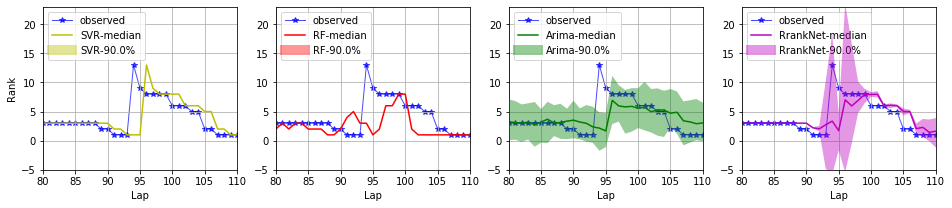

In [303]:
plot_forecasts(tss_arima, [target_svr, target_rf,target_arima, target_oracle],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.273359154409791, 20.558131277943744)
xlim: (25771680.0, 25771879.0)
ylim: (-7.262398672103882, 25.033903074264526)


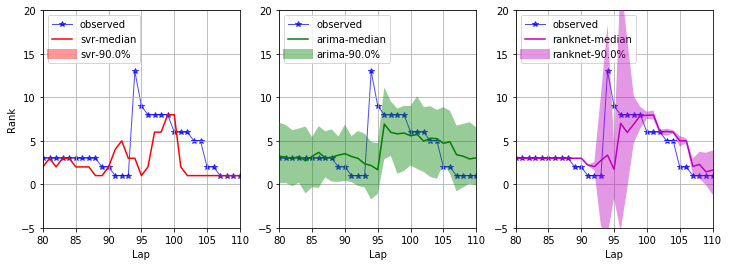

In [295]:
plot_forecasts(tss_arima, [target_rf, target_arima, target_oracle], 'ranknet-rf-rank-forecast')

xlim: (25771680.0, 25771879.0)
ylim: (-0.9500000000000001, 19.95)
xlim: (25771680.0, 25771879.0)
ylim: (-4.273359154409791, 20.558131277943744)
xlim: (25771680.0, 25771879.0)
ylim: (-7.262398672103882, 25.033903074264526)


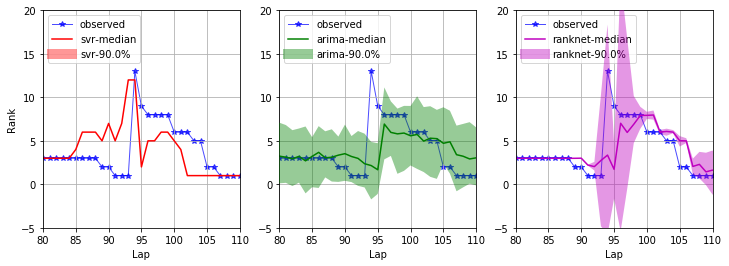

In [292]:
plot_forecasts(tss_arima, [target_xgb, target_arima, target_oracle], 'ranknet-xgb-rank-forecast')

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.273359154409791, 20.558131277943744)
xlim: (25771680.0, 25771879.0)
ylim: (-7.262398672103882, 25.033903074264526)


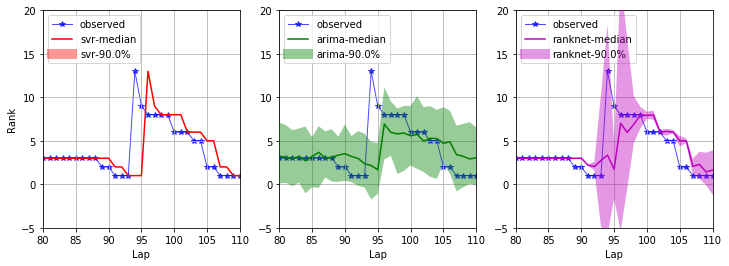

In [293]:
plot_forecasts(tss_arima, [target_svr, target_arima, target_oracle], 'ranknet-svr-rank-forecast')

In [233]:
%debug

> /scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/forecast.py(186)plot()
    184         import matplotlib.pyplot as plt
    185 
--> 186         label_prefix = "" if label is None else label + "-"
    187 
    188         for c in prediction_intervals:

ipdb> p label
Text(25771685, 0, '5')
ipdb> up
> <ipython-input-231-eb9f3c01f870>(84)plot_forecasts()
     82 
     83         forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
---> 84                                              color=colors[idx],label=labels[idx])
     85         #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
     86         #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')

ipdb> p label
*** NameError: name 'label' is not defined
ipdb> p labels[idx]
Text(25771685, 0, '5')
ipdb> p labels
<a list of 5 Text xticklabel objects>
ipdb> p *labels
*** SyntaxError: invalid syntax
ipd

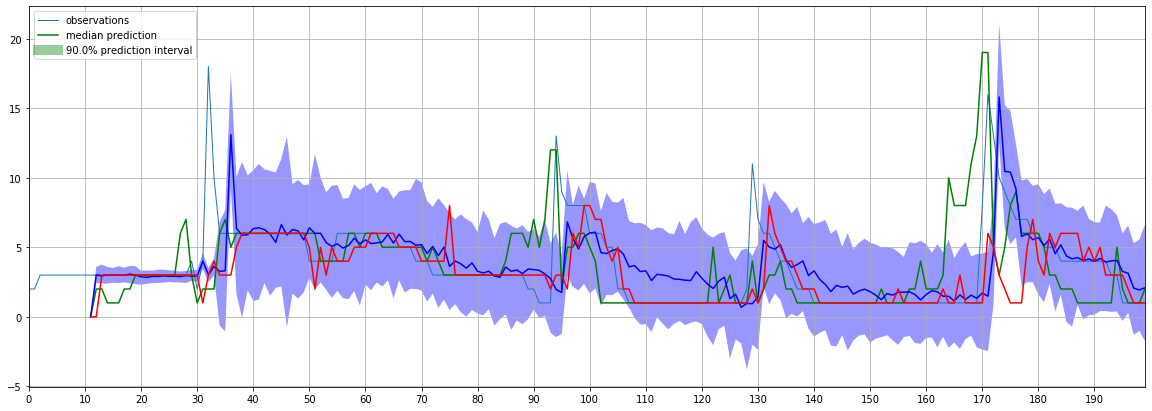

NameError: name 'idx' is not defined

In [160]:
plot_forecasts(tss_arima, [target_xgb, target_arima, target_ranknet], 'ranknet-rank-forecast')


xlim: (25771680.0, 25771879.0)
xlim: (25771680.0, 25771879.0)
xlim: (25771680.0, 25771879.0)


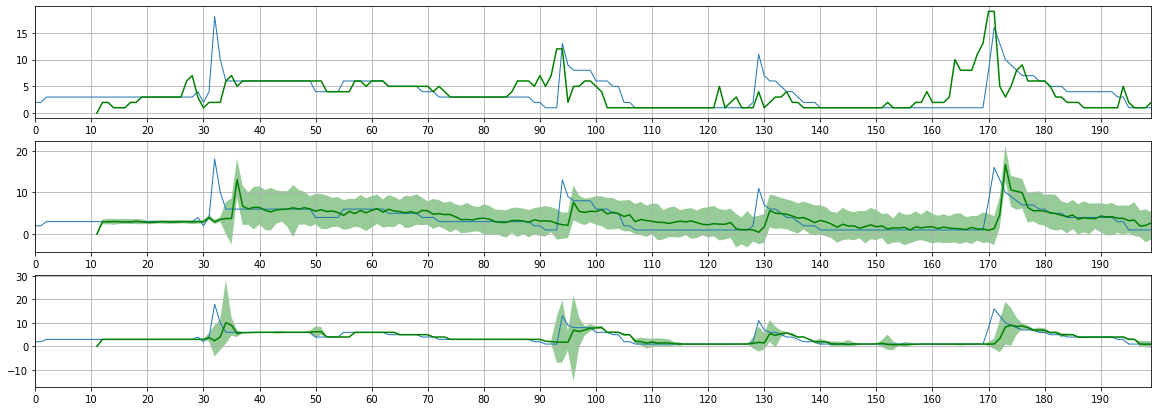

In [200]:
plot_forecasts(tss_arima, [target_xgb, target_arima, target_oracle], 'ranknet-rank-forecast')

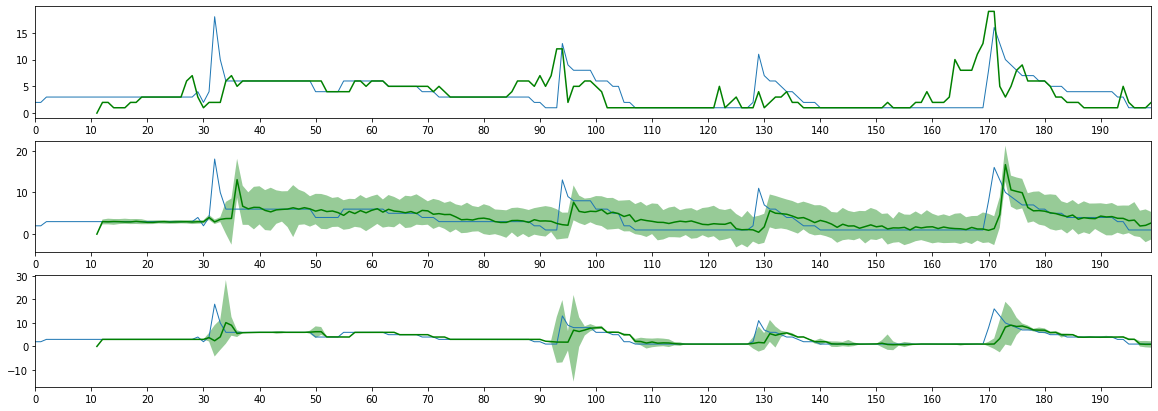

<Figure size 432x288 with 0 Axes>

In [185]:
#plot_forecasts(tss_arima, [target_xgb, target_arima, target_ranknet], 'ranknet-rank-forecast')
plot_forecasts(tss_arima, [target_xgb, target_arima, target_oracle], 'ranknet-rank-forecast')

In [174]:
target_ranknet.samples

array([[0., 0., 3., ..., 1., 1., 1.],
       [0., 0., 3., ..., 1., 1., 1.],
       [0., 0., 3., ..., 1., 1., 1.],
       ...,
       [0., 0., 3., ..., 1., 1., 1.],
       [0., 0., 3., ..., 1., 1., 1.],
       [0., 0., 3., ..., 1., 1., 1.]])